# Apache Spark: análisis de usuario
Cayetano Rodríguez Medina

Primero hay que importar el contexto de Spark y configurarlo. Le ponemos un nombre a la aplicación y especificamos cuál es el master de Spark al que nos queremos conectar.

In [1]:
from pyspark import SparkContext
from pyspark import SparkConf
conf = SparkConf().setAppName("user").setMaster("spark://tfmspark.ddns.net:7077")
sc = SparkContext.getOrCreate(conf=conf)

Especificamos el nombre del usuario al que vamos a analizar.

In [3]:
screen_name = 'CayeRodriguez'

## Análisis de personas (seguidores, amigos, alcanzabilidad)

El primer análisis a realizar se corresponde a los seguidores y amigos de los usuarios especificados. Para ello, usaremos los ficheros followers.jsonl y friends.jsonl, donde se encuentran almacenados todos los seguidores y amigos, del usuario.

Calculamos el número de seguidores, la alcanzabilidad y el número medio de seguidores de cada seguidor.

In [17]:
import json
hdfs = 'hdfs://tfmhdfs.ddns.net:9000/user/centos/files/'
followers_file = 'users/{}/followers.jsonl'.format(screen_name) 
        
reach = sc.textFile(hdfs + followers_file).map(lambda x: json.loads(x)['followers_count'])

In [18]:
sum_reach = reach.sum()

nfollowers = reach.count()

avg_followers = round(sum_reach / nfollowers, 2) 

Por otro lado, calculamos el número de amigos, amigos mutuos, amigos que no están siguiendo y seguidores a los que no sigue el usuario.

In [19]:
friends_file = 'users/{}/friends.jsonl'.format(screen_name) 


followers = sc.textFile(hdfs + followers_file).map(lambda x: json.loads(x)['screen_name'])
friends = sc.textFile(hdfs + friends_file).map(lambda x: json.loads(x)['screen_name'])

nfriends = friends.count()

mutual = friends.intersection(followers).count()

friends_not_following = nfriends - mutual

followers_not_followed = nfollowers - mutual

### Visualización de resultados

In [20]:
print("{} followers".format(nfollowers))
print("{} friends".format(nfriends))
print("{} mutual friends".format(mutual)) 
print("{} friends are not following back".format(friends_not_following)) 
print("{} followers are not followed back by {}".format(followers_not_followed, screen_name)) 
print("{} users reached by 1-degree connections".format(sum_reach)) 
print("Average number of followers for {}'s followers: {}".format(screen_name, avg_followers))

126 followers
246 friends
124 mutual friends
122 friends are not following back
2 followers are not followed back by CayeRodriguez
71506 users reached by 1-degree connections
Average number of followers for CayeRodriguez's followers: 567.51


## Análisis de influencia del usuario (retweets, favoritos)

Otra variable que analizaremos será con respecto a los tweets de dicho usuario, los retweets y favoritos, de cada uno de los tweets del usuario.

En el fichero user_timeline_usuario se encuentran todos los tweets del usuario, con lo cual, este será el fichero que utilizaremos para realizar el análisis.

In [21]:
timeline_file = 'user_timeline_{}.jsonl'.format(screen_name) 

timeline = sc.textFile(hdfs + timeline_file)
favorite_count = timeline.map(lambda x: json.loads(x)['favorite_count']).sum()
retweet_count = timeline.map(lambda x: json.loads(x)['retweet_count']).sum()

ntweets = timeline.count()

avg_favorite = round(favorite_count / ntweets, 2) 
avg_retweet = round(retweet_count / ntweets, 2) 
favorite_per_user = round(favorite_count / nfollowers, 2) 
retweet_per_user = round(retweet_count / nfollowers, 2) 

### Visualización de resultados

In [22]:
print("Total number of tweets: {}".format(ntweets))
print("Favorited {} times ({} per tweet, {} per user)".format(favorite_count, avg_favorite, favorite_per_user)) 
print("Retweeted {} times ({} per tweet, {} per user)".format(retweet_count, avg_retweet, retweet_per_user))

Total number of tweets: 2315
Favorited 53 times (0.02 per tweet, 0.42 per user)
Retweeted 248 times (0.11 per tweet, 1.97 per user)


## Palabras más usadas: Word Cloud

Ya que tenemos todos los tweets escritos por el usuario, podemos aprovechar para analizar las palabras más usadas por el mismo.

En primer lugar, vamos a realizar un filtrado del fichero, de modo que nos quedaremos únicamente con el campo 'text' del tweet, que es el que contiene el texto en sí, y posteriormente eliminaremos enlaces y menciones, de modo que el conteo de palabras funcione correctamente. 

In [28]:
texts = timeline.map(lambda x: json.loads(x)['text'])
texts.collect()

['@Ismawel_mar estabas viendo la peli de telecinco o que? xD',
 'Receive your free dev stickers, worldwide! @notifuse https://t.co/id97p4LrSX',
 'Mejor escena de #AquiNoHayQuienViva las lentejas',
 'Y esto también @alerguez1994  https://t.co/jI6hnHE0ae',
 '@alerguez1994 bum',
 'Feliz año a todos! :)',
 '@Franxi_rios @MiguePepper  https://t.co/ZB94hxlCbT',
 '@sergiosucino @alerodri01 si se puede si somos amigos en Facebook',
 '@sergiosucino @alerodri01 no je ahora probamos',
 '@sergiosucino @alerodri01 es compatible el juego de android con el de iOS?',
 '@alerodri01 así me gusta 👍🏻👍🏻',
 '@alerodri01 que juego es ese? ☺️',
 '@AnaPosu será que a ti te gusta levantarte a las 8 😒😒',
 '@AnaPosu nada nada...que hay algunas que tienen tiempo para siestas.....😴👀',
 '@AnaPosu como no...',
 'Feliz año a todos :)',
 'Me acabo de dar cuenta de que estaban echando piratas del caribe, harry potter y el señor de los anillos',
 'Piratas del caribe #bestfilmever',
 'Cómo prepararse una asignatura en 2 d

Tenemos que hacer limpieza en el texto de los tweets. Será interesante eliminar del texto la palabra RT que precede a cada tweet que haya sido retwitteado por otro usuario, además de las URLs y usuarios (precedidos de @), así como poner todo el texto en minúsculas o eliminar los elementos de puntuación.

In [32]:
import string
import re

clean = texts.map(lambda x: x.lower())
             .map(lambda x: re.sub(r"http\S+", "", x))
             .map(lambda x: re.sub(r"@\S+", "", x))
             .map(lambda x: re.sub(r"\\\S+", "", x))
             .map(lambda x: "".join(c for c in x if c not in ('!','.', ',',':', ';', '?', '(', ')', '[', ']')))
            .map(lambda x: ''.join(i for i in x if not i.isdigit()))

clean.collect()

[' estabas viendo la peli de telecinco o que xd',
 'receive your free dev stickers worldwide  ',
 'mejor escena de #aquinohayquienviva las lentejas',
 'y esto también   ',
 ' bum',
 'feliz año a todos ',
 '   ',
 '  si se puede si somos amigos en facebook',
 '  no je ahora probamos',
 '  es compatible el juego de android con el de ios',
 ' así me gusta 👍🏻👍🏻',
 ' que juego es ese ☺️',
 ' será que a ti te gusta levantarte a las  😒😒',
 ' nada nadaque hay algunas que tienen tiempo para siestas😴👀',
 ' como no',
 'feliz año a todos ',
 'me acabo de dar cuenta de que estaban echando piratas del caribe harry potter y el señor de los anillos',
 'piratas del caribe #bestfilmever',
 'cómo prepararse una asignatura en  días - tercera parte',
 ' \n',
 'vaya tela',
 'ya que se ve que no me van a dejar dormir en bastante tiempo me pondré a estudiar o intentarlo mas bien',
 'estar despierto a estas horas un sábado debería estar prohibido',
 ' porque están buenas',
 ' buenas',
 'tarde de megaco 😁😁 😞',


Una vez tenemos el texto limpio, separaremos todas las palabras.

In [33]:
words = clean.flatMap(lambda x: x.split(' '))
words.collect()

['',
 'estabas',
 'viendo',
 'la',
 'peli',
 'de',
 'telecinco',
 'o',
 'que',
 'xd',
 'receive',
 'your',
 'free',
 'dev',
 'stickers',
 'worldwide',
 '',
 '',
 'mejor',
 'escena',
 'de',
 '#aquinohayquienviva',
 'las',
 'lentejas',
 'y',
 'esto',
 'también',
 '',
 '',
 '',
 '',
 'bum',
 'feliz',
 'año',
 'a',
 'todos',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'si',
 'se',
 'puede',
 'si',
 'somos',
 'amigos',
 'en',
 'facebook',
 '',
 '',
 'no',
 'je',
 'ahora',
 'probamos',
 '',
 '',
 'es',
 'compatible',
 'el',
 'juego',
 'de',
 'android',
 'con',
 'el',
 'de',
 'ios',
 '',
 'así',
 'me',
 'gusta',
 '👍🏻👍🏻',
 '',
 'que',
 'juego',
 'es',
 'ese',
 '☺️',
 '',
 'será',
 'que',
 'a',
 'ti',
 'te',
 'gusta',
 'levantarte',
 'a',
 'las',
 '',
 '😒😒',
 '',
 'nada',
 'nadaque',
 'hay',
 'algunas',
 'que',
 'tienen',
 'tiempo',
 'para',
 'siestas😴👀',
 '',
 'como',
 'no',
 'feliz',
 'año',
 'a',
 'todos',
 '',
 'me',
 'acabo',
 'de',
 'dar',
 'cuenta',
 'de',
 'que',
 'estaban',
 'echando',
 'pirat

Lo siguiente que haremos será crear un RDD de pares, añadiendo un 1 a cada palabra. Para ello usaremos la función map de Spark, que ejecuta una función sobre cada elemento del RDD.

In [34]:
wordPairs = words.map(lambda x: (x,1))
wordPairs.collect()

[('', 1),
 ('estabas', 1),
 ('viendo', 1),
 ('la', 1),
 ('peli', 1),
 ('de', 1),
 ('telecinco', 1),
 ('o', 1),
 ('que', 1),
 ('xd', 1),
 ('receive', 1),
 ('your', 1),
 ('free', 1),
 ('dev', 1),
 ('stickers', 1),
 ('worldwide', 1),
 ('', 1),
 ('', 1),
 ('mejor', 1),
 ('escena', 1),
 ('de', 1),
 ('#aquinohayquienviva', 1),
 ('las', 1),
 ('lentejas', 1),
 ('y', 1),
 ('esto', 1),
 ('también', 1),
 ('', 1),
 ('', 1),
 ('', 1),
 ('', 1),
 ('bum', 1),
 ('feliz', 1),
 ('año', 1),
 ('a', 1),
 ('todos', 1),
 ('', 1),
 ('', 1),
 ('', 1),
 ('', 1),
 ('', 1),
 ('', 1),
 ('', 1),
 ('si', 1),
 ('se', 1),
 ('puede', 1),
 ('si', 1),
 ('somos', 1),
 ('amigos', 1),
 ('en', 1),
 ('facebook', 1),
 ('', 1),
 ('', 1),
 ('no', 1),
 ('je', 1),
 ('ahora', 1),
 ('probamos', 1),
 ('', 1),
 ('', 1),
 ('es', 1),
 ('compatible', 1),
 ('el', 1),
 ('juego', 1),
 ('de', 1),
 ('android', 1),
 ('con', 1),
 ('el', 1),
 ('de', 1),
 ('ios', 1),
 ('', 1),
 ('así', 1),
 ('me', 1),
 ('gusta', 1),
 ('👍🏻👍🏻', 1),
 ('', 1),
 ('que

Finalmente, procedemos a contar la frecuencia de cada palabra. Esto lo haremos utilizando una función de reducción de Spark: reduceByKey. Se agruparán todos los elementos del RDD que tengan la misma clave (la palabra) y se sumarán todos los 1s, de modo que obtendremos un RDD con todas las palabras junto a su frecuencia de aparición.

In [35]:
wordCounts = wordPairs.reduceByKey(lambda x, y: x+ y)
wordCounts.collect()

[('', 2322),
 ('mu', 17),
 ('"rassel', 1),
 ('peor', 15),
 ('vez', 19),
 ('underground', 1),
 ('tensioooooon', 1),
 ('b', 1),
 ('punta', 1),
 ('sentada', 1),
 ('vamo', 2),
 ('recolectiva"', 1),
 ('siii', 1),
 ('diferencia', 2),
 ('largo', 6),
 ('pedire', 1),
 ('piro', 1),
 ('selectividad', 4),
 ('indirectas', 1),
 ('numero', 3),
 ('vivimos', 1),
 ('chaqueta', 1),
 ('lleve', 3),
 ('programación', 15),
 ('para', 99),
 ('gustado', 30),
 ('#ojuio', 1),
 ('pueblo', 1),
 ('apocalipsis', 1),
 ('#todosconjuanan', 1),
 ('quitar', 2),
 ('uy', 2),
 ('fotocopia', 1),
 ('foto', 6),
 ('ninguno', 1),
 ('cellos', 1),
 ('deberían', 1),
 ('compras', 1),
 ('pierdes', 1),
 ('donut', 2),
 ('cagarme', 1),
 ('amame', 1),
 ('saltado', 1),
 ('altos', 1),
 ('deje', 3),
 ('"indivisibilidad"', 1),
 ('estudie', 1),
 ('asi', 27),
 ('determinante', 1),
 ('interseccion', 1),
 ('amador', 1),
 ('verdad', 11),
 ('tuenti"', 1),
 ('world', 3),
 ('😕', 1),
 ('tonto', 1),
 ('habeis', 3),
 ('neperianos', 1),
 ('mejores', 2),


Ahora, tansformamos el RDD resultante en un diccionario, y eliminamos algunos elementos que pueden distorsionar el resultado, como los elementos vacíos.

In [36]:
wordCountsDict = wordCounts.collectAsMap()
del (wordCountsDict[''])
del (wordCountsDict['"'])
del (wordCountsDict['-'])

delete_list = ["rt", "que", "de", "a", "y", "no", "si", "el", "la", "los", "las", "un", "una", "unos", "unas",
               "en", "lo", "es", "ya", "por", "yo", "tu", "me", "se", "te", "con", "mi", "para", "he", "ha", "o",
               "al", "pa", "hay", "del", "mas", "más", "como", "has", "ni", "sin", "eso", "le", "este", "esta",
               "hace", "hacer", "pero", "hasta", "va", "porque", "pues", "menos", "han", "to", "tiene", "asi", "así",
               "aquí", "algo", "x", "ir", "son", "estoy", "voy", "nos", "muy", "mucho", "luego", "estos", "estas"]
for word in delete_list:
    del (wordCountsDict[word])

Nos interesa ordenar todas las palabras por su frecuencia, sin embargo, los diccionarios no se pueden ordenar (por definición). Entonces, usaremos la función sorted para convertir el diccionario en una lista ordenada según la frecuencia, y en orden descendente.

In [37]:
sortedList = sorted(wordCountsDict.items(), key=lambda x: x[1], reverse=True)
sortedList

[('xd', 224),
 ('mañana', 116),
 ('tengo', 84),
 ('hoy', 63),
 ('buenas', 62),
 ('ahora', 56),
 ('examen', 54),
 ('noches', 53),
 ('cuando', 47),
 ('vamos', 47),
 ('ver', 46),
 ('hora', 45),
 ('vídeo', 42),
 ('nada', 42),
 ('todo', 40),
 ('bien', 39),
 ('u_u', 38),
 ('estudiar', 35),
 ('#twitteroff', 32),
 ('creo', 32),
 ('tiempo', 32),
 ('gustado', 30),
 ('horas', 29),
 ('tarde', 29),
 ('todos', 29),
 ('casa', 28),
 ('sevilla', 27),
 ('igual', 25),
 ('está', 24),
 ('ti', 23),
 ('mejor', 23),
 ('mal', 23),
 ('dia', 22),
 ('física', 22),
 ('ser', 21),
 ('alguien', 21),
 ('vida', 21),
 ('da', 21),
 ('sueño', 21),
 ('minutos', 20),
 ('tema', 20),
 ('bueno', 20),
 ('clase', 20),
 ('lengua', 20),
 ('comer', 19),
 ('cuenta', 19),
 ('bus', 19),
 ('vez', 19),
 ('dormir', 19),
 ('estudiando', 19),
 ('viene', 19),
 ('mates', 18),
 ('otra', 18),
 ('gusta', 18),
 ('coche', 18),
 ('queda', 18),
 ('po', 18),
 ('semana', 17),
 ('mu', 17),
 ('vaya', 17),
 ('parece', 17),
 ('desde', 17),
 ('llevo', 16)

### Visualización de resultados

Una vez tenemos la lista ordenada de las palabras con su frecuencia, podemos crear un word cloud (una nube de palabras en la que el tamaño de cada palabra se corresponde con su frecuencia - a mayor tamaño, mayor frecuencia).

In [38]:
from wordcloud import WordCloud, STOPWORDS

Le pasamos a la función de creación del word cloud la lista ordenada de palabras.

In [39]:
# Generate a word cloud image
wordcloud = WordCloud(max_font_size=40).generate_from_frequencies(sortedList)

Por último, imprimimos la imagen con el resultado.

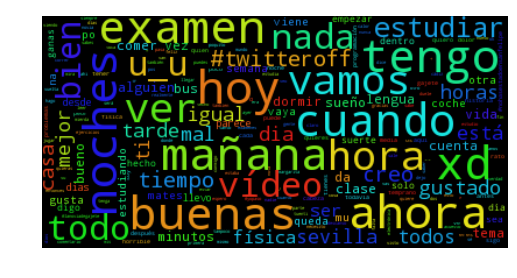

In [40]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Se puede deducir que el usuario al que estamos analizando es un estudiante, debido a que entre las palabras más usadas aparecen "examen" o "estudiar".